## Partial inference and Posterior sampling with the Hierarchical Variational Auto-Encoder (HVAE)

This notebook shows example use-cases of the Hierarchical VAE as a generative model in the zea framework.

Note that the HVAE is quite large (**24M**) and computationally expensive, a GPU should be used if available.

The model works with Tensorflow, Jax, and Pytorch backend.

In [1]:
%%capture
%pip install zea

First, we select a Keras backend, suppress logging, select a device to run on and set the matplotlib style using zea.

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [3]:
from keras import ops, random
import matplotlib.pyplot as plt

from zea import init_device
from zea.display import scan_convert_2d
from zea.visualize import set_mpl_style, plot_image_grid
from zea.models.hvae import HVAE
from zea.backend.tensorflow.dataloader import make_dataloader
from zea.agent.selection import UniformRandomLines

init_device(verbose=False)
set_mpl_style()

zea: Using backend 'jax'


2025-12-18 15:02:29.619433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766070149.633577 3263557 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766070149.637815 3263557 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766070149.652439 3263557 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766070149.652459 3263557 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766070149.652461 3263557 computation_placer.cc:177] computation placer alr

### Data

The HVAE model is trained on short 2D ultrasound acquisitions at a resolution of `256x256x3`, where the last dimension denotes 3 subsequent video frames. We can download a batch of data from the `CAMUS` dataset from `zeahub` on `HuggingFace`.

In [4]:
DATA_SIZE = 256

val_dataset = make_dataloader(
    "hf://zeahub/camus-sample/val",
    key="data/image",
    batch_size=4,
    image_range=[-45, 0],
    n_frames=3,
    clip_image_range=True,
    normalization_range=[-1, 1],
    image_size=(DATA_SIZE, DATA_SIZE),
    resize_type="resize",
    shuffle=True,
    seed=1234,
)
batch = next(iter(val_dataset))

zea: Searching /root/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val for ['.hdf5', '.h5'] files...
zea: Loading cached result for _find_h5_file_shapes.
zea: Dataset was validated on December 17, 2025
zea: Remove /root/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/validated.flag if you want to redo validation.
zea: WARNING H5Generator: Not all files have the same shape. This can lead to issues when resizing images later....
zea: H5Generator: Shuffled data.


I0000 00:00:1766070154.355132 3263557 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43493 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:81:00.0, compute capability: 8.9


zea: H5Generator: Shuffled data.


### Model
The default HVAE can be loaded with the `"hvae"` preset.

If you care about the architecture of the neural network, you can uncomment the `model.network.print_model()` line.

In [5]:
model = HVAE.from_preset("hvae")
# model.network.print_model()

We can reconstruct an input image by calling the model, as well as calculate the log_density of the image under the data that the model was trained on.

The top row shows the input image, and the bottom row the corresponding reconstructed image.

In [6]:
(
    out,
    _,
    _,
) = model.call(batch)
elbo = model.log_density(batch)

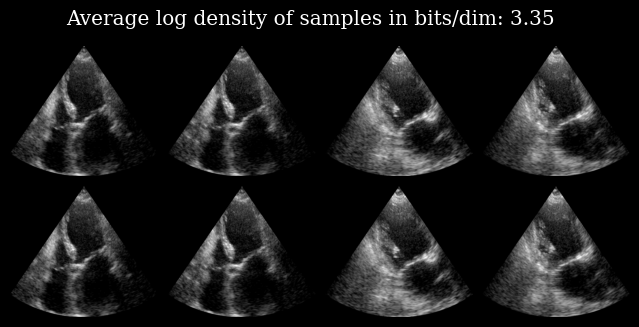

In [7]:
images = (ops.concatenate([out, batch], axis=0) + 1) / 2
images = images[..., -1]
images = scan_convert_2d(images, rho_range=(0, DATA_SIZE), theta_range=(-0.6, 0.6))[0]
fig, _ = plot_image_grid(images)
fig.suptitle(f"Average log density of samples in bits/dim: {elbo:.2f}")
plt.savefig("hvae_reconstruction_example.png", bbox_inches="tight", dpi=100)

### Partial inference

Additionally, We can have a look inside the HVAE architecture to see how the image is formed inside the generative model. 

We do this with a custom function `partial_inference` that only passes the input image to a fraction of the layers in the model. The rest of the image is then created with the prior. This lets us look at the way information is propagating in the compressed space.

Let's try this with the first image (top-left) of the previous example.

In [ ]:
# What would happen if we only allow the first 3% of the layers to do inference? or 12%? etc.
inference_fractions = [0.03, 0.12, 0.18, 0.3, 0.5, 0.6, 1.0]
# For every experiment, we create 6 samples to show the divergence
# of the path after stopping inference.
n_samples = 6

out_partial = []
for frac in inference_fractions:
    out_partial.append(
        model.partial_inference(
            measurements=batch[0:1],
            num_layers=frac,
            n_samples=n_samples,
        )
    )
print(f"Every experiments generates a {out_partial[0][0].shape} tensor.")

Every experiments generates a (6, 256, 256, 3) tensor.


Next, we create an image from the samples at every inference fraction, as well as a variance map.

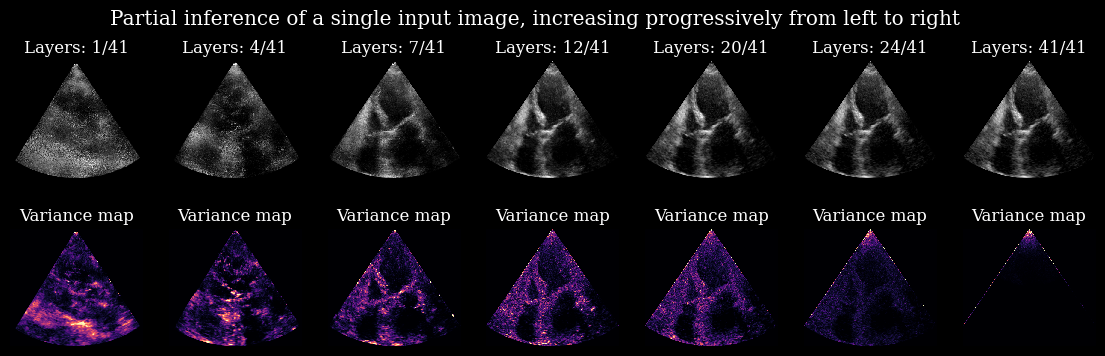

In [ ]:
# Plotting
plot_images = []
plot_variances = []
for image_set in out_partial:
    # We only visualize the last frame of the 3-frame output of the model.
    last_frame = image_set[0, ..., -1]

    # For visualization, we create an image by randomly selecting one of
    # the samples for every pixel.
    # This gives an idea of the diversity of the samples.
    mapping = random.randint(ops.shape(last_frame)[1:3], 0, n_samples)
    plot_image = ops.take_along_axis(last_frame, mapping[None, ...], axis=0).squeeze(0)
    plot_images.append((plot_image + 1) / 2)

    # Additionally, we show a variance map to indicate model uncertainty at pixel level.
    plot_variances.append(ops.var(last_frame, axis=0))

plot_images = ops.stack(plot_images, axis=0)
plot_variances = ops.stack(plot_variances, axis=0)

# We convert the images from the polar domain to Cartesian
plot_images = scan_convert_2d(plot_images, rho_range=(0, DATA_SIZE), theta_range=(-0.6, 0.6))[0]
plot_variances = scan_convert_2d(plot_variances, rho_range=(0, DATA_SIZE), theta_range=(-0.6, 0.6))[
    0
]

# Clip variance maps for better visualization
quantiles = ops.quantile(plot_variances, 0.999, axis=(1, 2), keepdims=True)

fig, axs = plt.subplots(2, len(inference_fractions), figsize=(len(inference_fractions) * 2, 2 * 2))
for i in range(len(inference_fractions)):
    axs[0, i].imshow(plot_images[i], cmap="gray")
    axs[0, i].set_title(f"Layers: {int(inference_fractions[i] * model.depth)}/{model.depth}")
    axs[0, i].axis("off")
    axs[1, i].imshow(plot_variances[i], vmin=0, vmax=quantiles[i], cmap="magma")
    axs[1, i].set_title("Variance map")
    axs[1, i].axis("off")
fig.suptitle(
    "Partial inference of a single input image, increasing progressively from left to right"
)
plt.savefig("hvae_partial_inference_example.png", bbox_inches="tight", dpi=100)

Here you can nicely see the process in which uncertainty is resolved within the model for this specific input image. Every layer carves out a small part of the prior to better align all the samples with the input image.

*Note: The sharp edges of the variance maps stem from artifacts in the EchoNetLVH dataset that the model was trained on.

---

### Posterior sampling

The HVAE can also be used with `zea.agent`, similar to the Diffusion Model examples.

In this example, we will subsample the ultrasound images and let the model fill in the gaps.

In [10]:
# We subsample to 24/256 (9.4%) of the columns (lines).
num_lines = 24
agent = UniformRandomLines(
    n_actions=num_lines,
    n_possible_actions=DATA_SIZE,
    img_width=DATA_SIZE,
    img_height=DATA_SIZE,
)
# The model predicts three frames at once, so we need three masks.
mask = [agent.sample(batch_size=4)[1] for _ in range(3)]
mask = ops.stack(mask, axis=-1)

# We set everything outside of the mask to -1.0, as un-observed.
subsampled_batch = ops.where(mask, batch, -1.0)

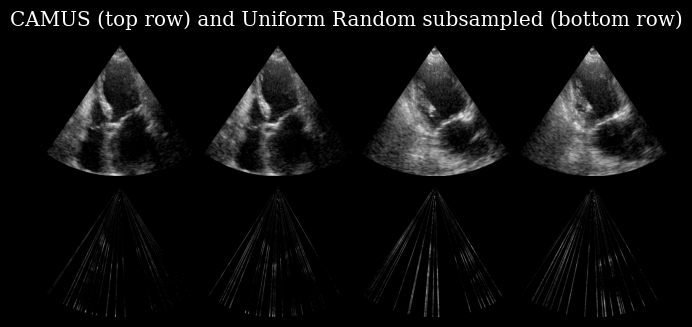

In [11]:
# Plotting
plot_images = ops.concatenate([batch, subsampled_batch], axis=0)[..., -1]
plot_images = (plot_images + 1) / 2
plot_images = scan_convert_2d(plot_images, rho_range=(0, DATA_SIZE), theta_range=(-0.6, 0.6))[0]
plot_image_grid(plot_images)
plt.suptitle("CAMUS (top row) and Uniform Random subsampled (bottom row)")
plt.savefig("hvae_subsampled_example.png", bbox_inches="tight", dpi=100)

The bottom row of this image is used as a model input, which has as a task to recover the corresponding image in the top row.

For this task the encoder of the HVAE needs to be retrained, so we load in a specialized version of the weights, `lvh_ur24`:
- `lvh`: The model is trained on EchonetLVH
- `ur`: The model was trained with UniformRandom subsampling
- `24`: The model had 24/256 lines available during training

An overview of all versions is available on the `zeahub` HuggingFace, or you can retrain you own with zea!

In [12]:
model = HVAE.from_preset("hvae", version="lvh_ur24")
# Use the subsampled batch as input and generate 4 posterior samples, just like before.
posterior_samples = model.posterior_sample(subsampled_batch, n_samples=4)

E1218 15:04:57.352021 3263557 hlo_lexer.cc:443] Failed to parse int literal: 84667041256873967512


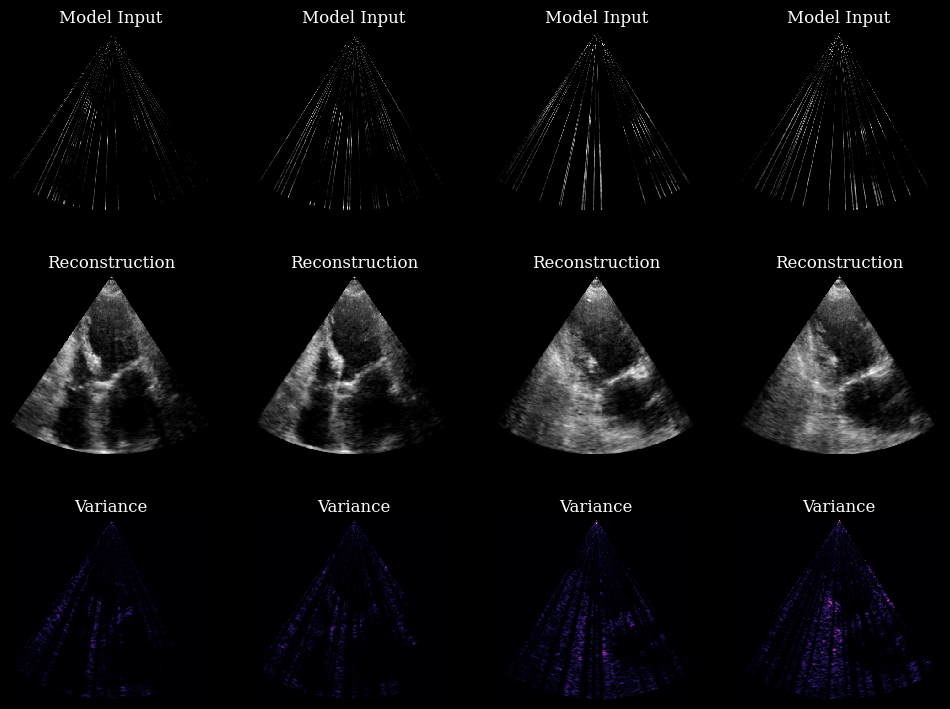

In [13]:
# Plotting
plot_input = scan_convert_2d(
    subsampled_batch[..., -1], rho_range=(0, DATA_SIZE), theta_range=(-0.6, 0.6), fill_value=-1
)[0]

# For reconstruction we visualize the last frame of a single sample from the model
plot_sample = (posterior_samples[:, 0, ..., -1] + 1) / 2
plot_sample = scan_convert_2d(plot_sample, rho_range=(0, DATA_SIZE), theta_range=(-0.6, 0.6))[0]

plot_variance = ops.var(posterior_samples, axis=1)[..., -1]
plot_variance = scan_convert_2d(plot_variance, rho_range=(0, DATA_SIZE), theta_range=(-0.6, 0.6))[0]

fig, axs = plt.subplots(3, 4, figsize=(12, 9))
for ax in axs.flatten():
    ax.axis("off")
for i in range(4):
    axs[0, i].imshow(plot_input[i], cmap="gray")
    axs[0, i].set_title("Model Input")
    axs[1, i].imshow(plot_sample[i], cmap="gray")
    axs[1, i].set_title("Reconstruction")
    im = axs[2, i].imshow(plot_variance[i], cmap="magma")
    axs[2, i].set_title("Variance")
plt.savefig("hvae_posterior_example.png", bbox_inches="tight", dpi=100)

In these 4 examples, the model is using every layer. The variance maps are no longer related to the model's inner workings, but the uncertainty of the ground truth given a partial observation!